# Importando Bibliotecas

In [302]:
# Para manipulação de dados
import pandas as pd
import numpy as np

# Para visualização de dados
import matplotlib.pyplot as plt
import matplotlib.cm as cm # transformar valores numéricos em cores - colormaps (palleta de cores)
import matplotlib.colors as mcolors # manipulação de cores, conversões entre formatos (hex, RGB, etc.)
import matplotlib.ticker as mticker # formatar e controlar os valores dos eixos

import seaborn as sns
from datetime import datetime

# Para lidar com valores ausentes
from sklearn.impute import SimpleImputer

# Aplica as configurações de fonte para os gráficos
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']

# Carregando os dados

In [303]:
# Carregar os dados do arquivo csv em um objeto Pandas DataFrame
df = pd.read_csv("saida/imoveis_com_bairros.csv")

# Exibir as primeiras 5 linhas do DataFrame
df.head()

,bairro,area,quartos,banheiros,vagas,hospital,gas_station,school,supermarket,restaurant,pharmacy,preco
0,Vila Passos,70,2.0,1.0,1.0,1,1,1,1,1,1,260000
1,Parque Mondesir,120,4.0,1.0,2.0,1,1,1,1,1,0,350000
2,Cidade Industrial,137,3.0,1.0,2.0,1,1,1,1,1,1,300000
3,Santo Antônio,142,3.0,1.0,3.0,1,0,1,1,1,1,370000
4,Vila Brito,300,3.0,5.0,3.0,1,1,1,1,1,0,499000


# Descrição dos dados

## Estrutura

In [304]:
# Verificar a estrutura do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bairro       832 non-null    object 
 1   area         832 non-null    int64  
 2   quartos      559 non-null    float64
 3   banheiros    571 non-null    float64
 4   vagas        462 non-null    float64
 5   hospital     832 non-null    int64  
 6   gas_station  832 non-null    int64  
 7   school       832 non-null    int64  
 8   supermarket  832 non-null    int64  
 9   restaurant   832 non-null    int64  
 10  pharmacy     832 non-null    int64  
 11  preco        832 non-null    int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 78.1+ KB


## Preenchendo valores nulos

In [305]:
# Quando temos um imóvel do tipo terreno, não há quartos, vagas ou banheiros, etc. L
# Logo é importante preencher esses valores com 0.

cols = [
    'quartos',
    'banheiros',
    'vagas', 'hospital',
    'gas_station','school',
    'supermarket',
    'restaurant',
    'pharmacy'
]

# Preenchendo os valores NA com 0
df[cols] = df[cols].fillna(0)

# Temos um imóvel na Área Rural que tem área igual a Zero.
# Vamos preencher esse valor com a Mediana da área nesse bairro
# Filtra o DataFrame para pegar as áreas do bairro "Área Rural de Lorena"
rural = df[df['bairro']=='Área Rural de Lorena']

# Calcula a mediana ignorando valores zero na coluna 'area'
mediana = rural[rural['area'] != 0]['area'].median()

# Preenche área 0 com a mediana nos imóveis da Área Rural de Lorena
df.loc[
    (df['bairro'] == 'Área Rural de Lorena') & (df['area'] == 0), # condições para localizar os valores
    'area' # na coluna área
    ] = int(mediana_area) # definindo esses valores como a mediana

# DataFrame após preenchido
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bairro       832 non-null    object 
 1   area         832 non-null    int64  
 2   quartos      832 non-null    float64
 3   banheiros    832 non-null    float64
 4   vagas        832 non-null    float64
 5   hospital     832 non-null    int64  
 6   gas_station  832 non-null    int64  
 7   school       832 non-null    int64  
 8   supermarket  832 non-null    int64  
 9   restaurant   832 non-null    int64  
 10  pharmacy     832 non-null    int64  
 11  preco        832 non-null    int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 78.1+ KB


# Estatísticas

In [306]:
# Resumo estatístico das variáveis numéricas do DataFrame.
df.describe().map('{:,.0f}'.format)

,area,quartos,banheiros,vagas,hospital,gas_station,school,supermarket,restaurant,pharmacy,preco
count,832,832,832,832,832,832,832,832,832,832,832
mean,"477,496",2,1,2,1,1,1,1,1,1,"1,731,923"
std,"12,586,527",2,2,5,0,0,0,0,0,0,"5,385,657"
min,1,0,0,0,0,0,0,0,0,0,"75,000"
25%,130,0,0,0,1,1,1,1,1,1,"299,000"
50%,235,2,1,1,1,1,1,1,1,1,"468,000"
75%,750,3,2,2,1,1,1,1,1,1,"960,000"
max,"363,000,000",50,50,80,1,1,1,1,1,1,"78,000,000"


## **Histogramas e Boxplots**

### Funções utilitárias para boxplots e histogramas

In [307]:
def plot_boxplot(df, cols, axes):
    # Paleta para os boxplots (cor base das caixas)
    box_palette = sns.color_palette("Set2", n_colors=len(cols))
    cmap = sns.color_palette("plasma", as_cmap=True)  # Para os outliers

    for ax, col, box_color in zip(axes, cols, box_palette):
        # Boxplot base
        sns.boxplot(x=df[col], ax=ax, color=box_color, width=0.5, fliersize=0)

        # Detecta outliers
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers = df[col][(df[col] < lower) | (df[col] > upper)]

        # Desenha os outliers com cor em escala quente
        if not outliers.empty:
            norm = (outliers - outliers.min()) / (outliers.max() - outliers.min() + 1e-9)
            colors = cmap(norm.to_numpy())
            ax.scatter(outliers, np.full(len(outliers), 0), color=colors, zorder=10, s=40, edgecolor='black', linewidth=0.5)

        # Estética
        ax.set_title(f'Boxplot de {col.capitalize()}', fontsize=10, weight='bold')
        ax.set_xlabel(col, fontsize=10)

    plt.tight_layout()


# Função para plotar histogramas
def plot_histogram(df, cols, axes):
    palette = sns.color_palette("Set2", n_colors=len(cols))  # ou "pastel", "husl", etc.
    for ax, col, color in zip(axes, cols, palette):
        sns.histplot(data=df, x=col, ax=ax, kde=False, bins=20,
                     color=color, edgecolor="black")
        ax.set_title(f'Histograma de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel("Frequência")

# Função principal para desenhar gráficos
def plot_graphs(df, cols, graph_type):
    num_cols = len(cols)
    n_rows, n_cols = 2, 3  # ajuste conforme o número de colunas
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
    axes = axes.flatten()

    if graph_type == 'boxplot':
        plot_boxplot(df, cols, axes)
    elif graph_type == 'histogram':
        plot_histogram(df, cols, axes)
    else:
        raise ValueError("graph_type deve ser 'boxplot' ou 'histogram'")

    # Oculta os subplots extras
    for ax in axes[num_cols:]:
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f"{graph_type}s_seaborn.png")
    plt.show()

#### **Colunas a serem utilizadas para criar boxplots e histogramas**

In [308]:
cols = ["preco","area","quartos","banheiros","vagas"]

### **Boxplots com outliers**

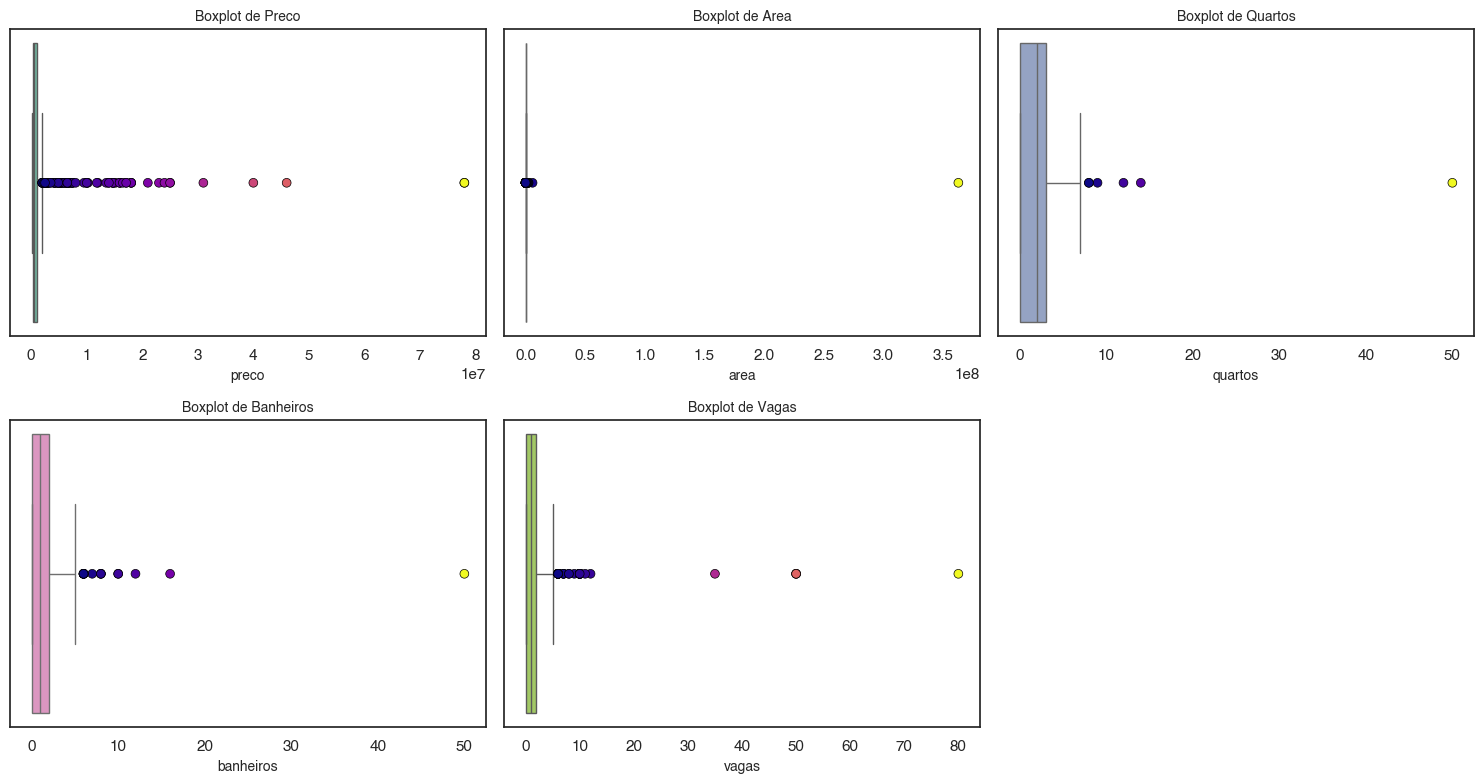

In [309]:
plot_graphs(df, cols, "boxplot")

### **Histogramas com outliers**

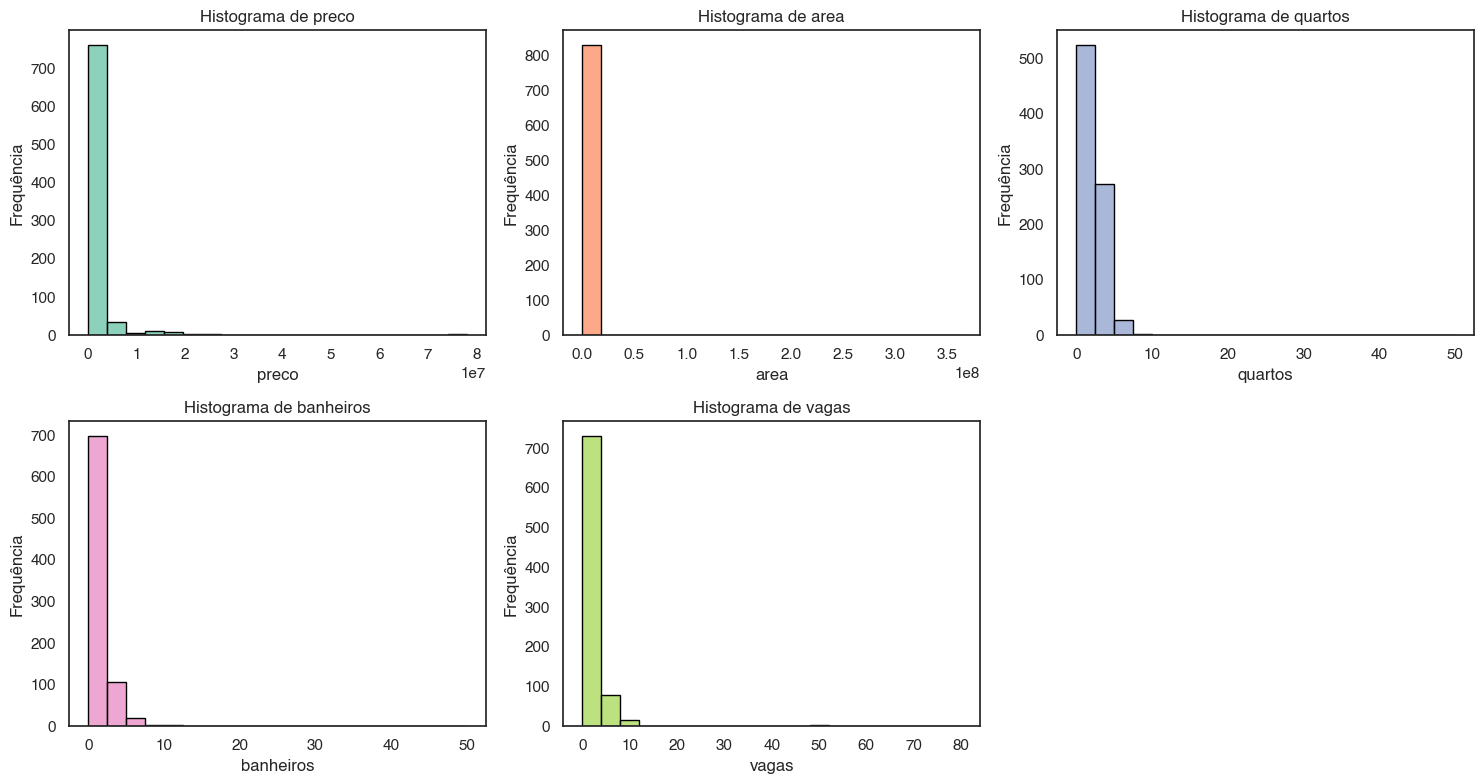

In [310]:
plot_graphs(df, cols, "histogram")

## **Remoção de Outliers**

In [311]:
# OPÇÃO 1): Função personalizada para remoção de outliers
def remover_outliers(df):
    col_filtro = {
        "area": 3000, #área do terreno
        "preco": 3000000, #preco do imóvel/terreno
        "quartos": 10, #número de quartos se houver
        "banheiros": 10, #número de banheiros se houver
        "vagas": 10 #número de vagas se houver
    }

    for col, limite in col_filtro.items():
        df = df[(df[col].isna()) | (df[col] < limite)]

    df_filtrado = df.copy()
    return df_filtrado

# OPÇÃO 2): Função que usa quantis para remoção de outliers
def remover_outliers_quantis(df, colunas=None, inferior=0.01, superior=0.99):    
    if colunas is None:
        colunas = df.select_dtypes(include=['number']).columns
    
    df_filtrado = df.copy()
    
    for col in colunas:
        q_inf = df[col].quantile(inferior)
        q_sup = df[col].quantile(superior)
        df_filtrado = df_filtrado[
        (
            df_filtrado[col].isna()) | 
            ((df_filtrado[col] >= q_inf) &
             (df_filtrado[col] <= q_sup
             )                              )
        ]
    
    return df_filtrado

# removendo outliers por limites personalizados (OPÇÃO 1)
df_sem_outliers = remover_outliers(df)
# removendo outliers por quantis (definir limite inferior e superior - OPÇÃO 2)
#df_sem_outliers = remover_outliers_quantis(df, colunas=cols)

### **Salvando dados sem outliers para arquivo .csv**

In [312]:
df_sem_outliers.to_csv("saida/imoveis_sem_outliers.csv", index=False)

## **Boxplot sem outliers**

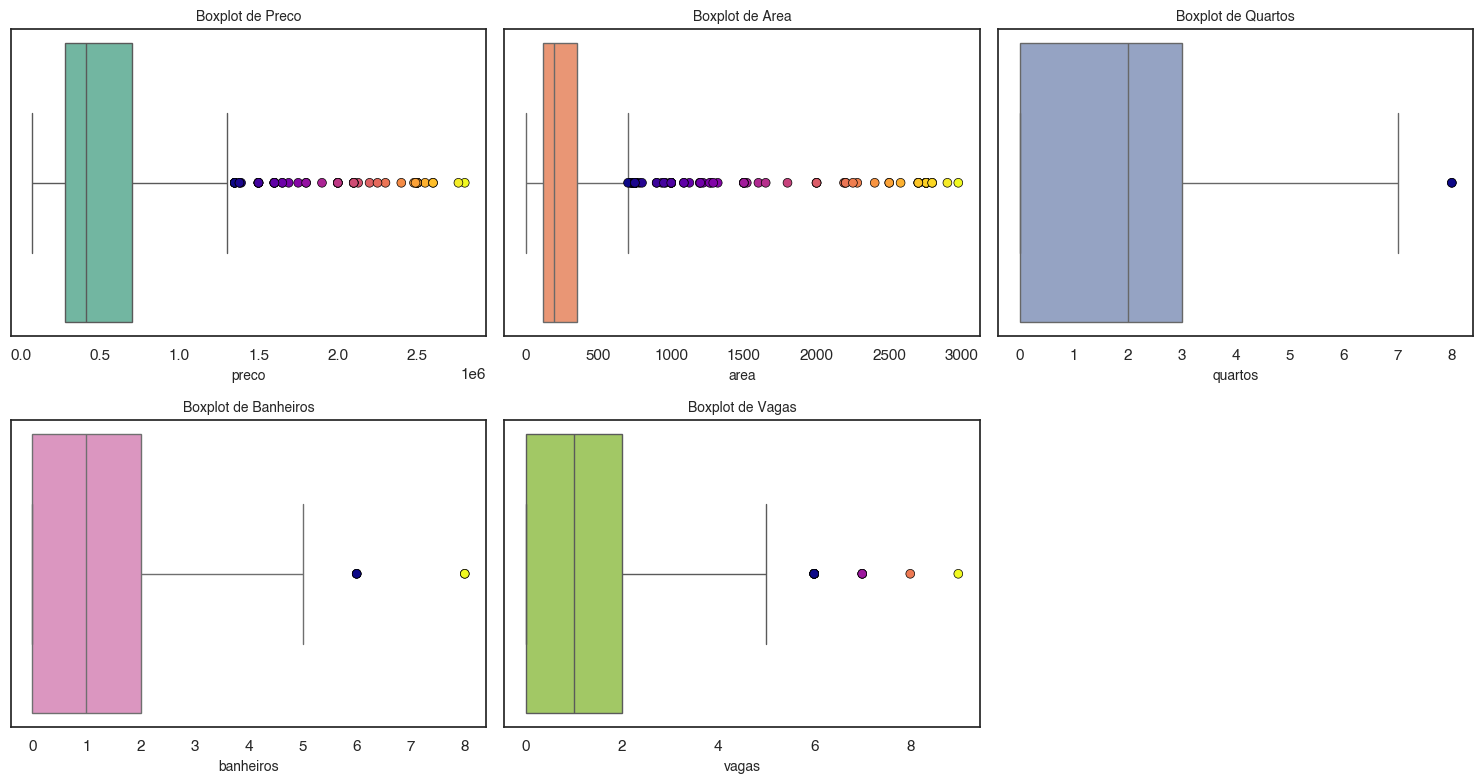

In [313]:
plot_graphs(df_sem_outliers,cols, "boxplot")

### **Histogramas sem outliers**

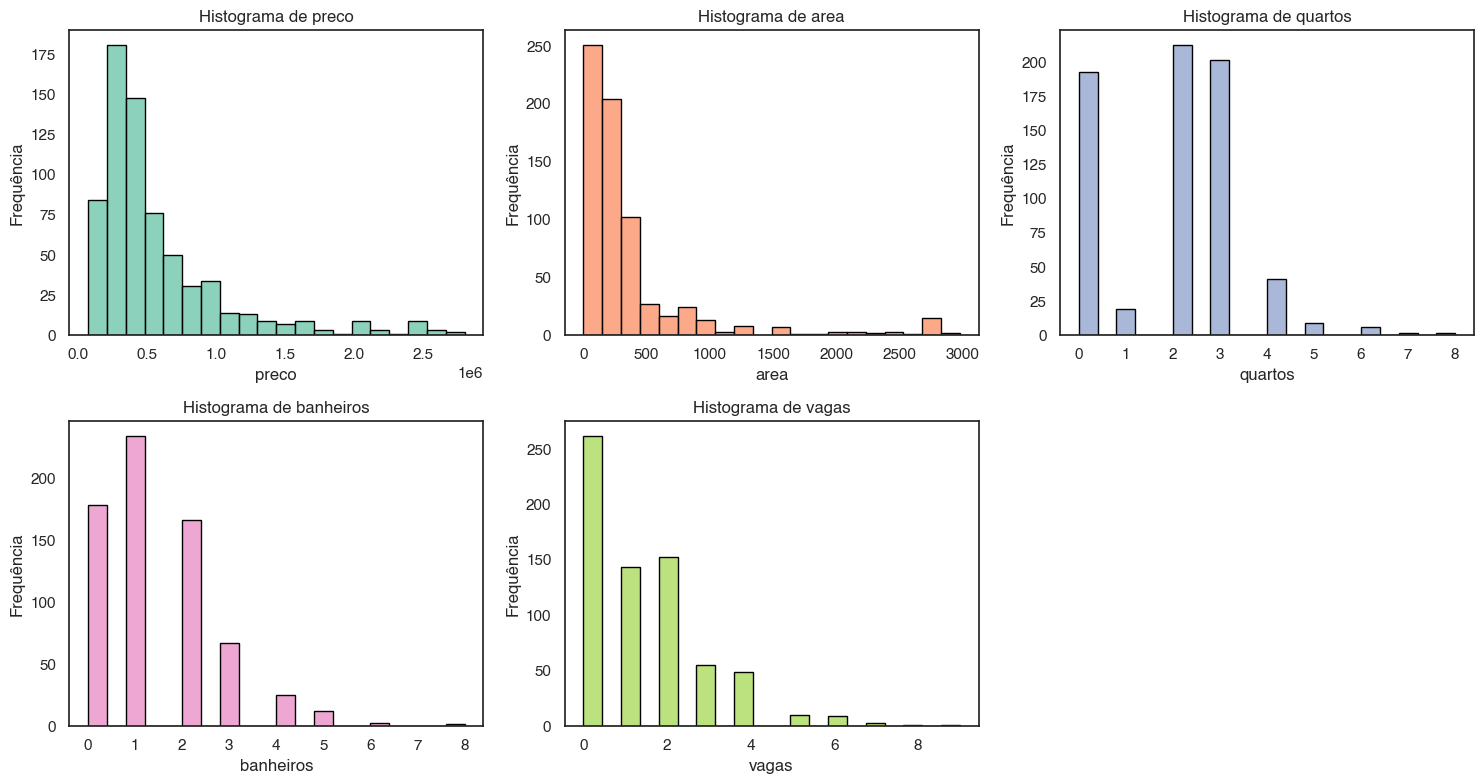

In [314]:
plot_graphs(df_sem_outliers, cols, "histogram")

## **Correlação**

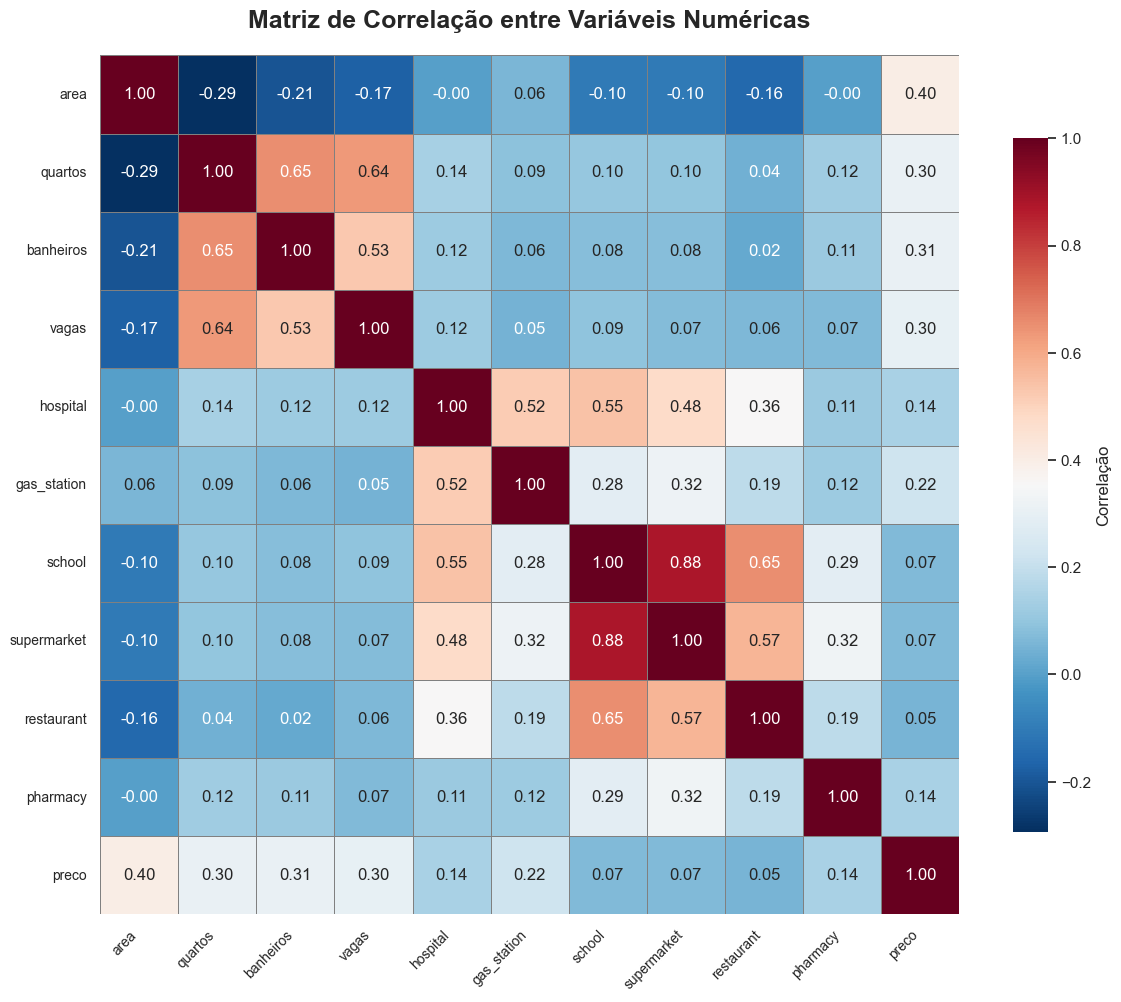

In [315]:
# Extrai das colunas numéricas para cálculo da correlação
df_num = df_sem_outliers.select_dtypes(include=['int64', 'float64'])

# Calcula a matriz de correlação
correlacao = df_num.corr()

# Configura o tema visual
sns.set_theme(style="white")

# Cria o heatmap com estilo aprimorado
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlacao,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",            # Paleta de cores com bom contraste
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8, "label": "Correlação"},
    square=True
)

# Ajustes no título e nos rótulos dos eixos
plt.title("Matriz de Correlação entre Variáveis Numéricas", fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

# Salvando a imagem no diretório raíz
plt.savefig("matriz_correlacao.png", dpi=300, bbox_inches='tight')

# Exibe o gráfico
plt.show()

## **Gráfico de Barras**

### **Função para criar gráficos de Barras**

In [316]:
# Cria as cores das barras e define a cor dos rótulos com base na luminosidade
def definir_cores(valores, colormap):
    norm = mcolors.Normalize(vmin=min(valores), vmax=max(valores))
    cmap = plt.get_cmap(colormap)
    
    # Gera uma lista de cores bem distribuídas do colormap
    bar_colors = [cmap(i) for i in np.linspace(0.1, 0.9, len(valores))]  # evita extremos
    bar_colors = bar_colors[::-1] #colocando as cores quentes primeiro
    label_colors = []

    for cor in bar_colors:
        r, g, b = cor[:3]  # ignora alpha se presente
        luminosidade = 0.2126 * r + 0.7152 * g + 0.0722 * b
        cor_rotulo = 'white' if luminosidade < 0.5 else 'black'
        label_colors.append(cor_rotulo)

    return bar_colors, label_colors


# Cria os rótulos customizados para as barras, dependendo do tipo de valor dos dados
def formatar_bar_labels(valor, tipo_valor):
    if tipo_valor == "moeda_br":
        valor_formatado = f'R$ {valor:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')
    elif tipo_valor == "decimal":
        valor_formatado = f'{valor:,.2f}'.replace(',', 'X').replace('.', ',').replace('X', '.')
    else:
        valor_formatado = valor
    return valor_formatado

# Função para formatar dinamicamente os eixos x e y
def formatar_eixo(ax, eixo, rotacao, label, ha, tamanho_fonte):
    # Define e formata o rótulo do eixo dinamicamente
    getattr(ax, f'set_{eixo}label')(label) # acessa dinamicamente set_x/ylabel passando o parametro label
    label_obj = ax.xaxis.label if eixo == 'x' else ax.yaxis.label # instancia o rótulo de cada eixo como label_obj
    label_obj.set_fontsize(tamanho_fonte) # alterando o tamanho da fonte do rótulo do eixo

    # Rotaciona os rótulos do eixo especificado, caso haja o parametro rotação
    if rotacao is not None:
        ticklabels = ax.get_xticklabels() if eixo == 'x' else ax.get_yticklabels()
        plt.setp(ticklabels, rotation=rotacao, ha=ha)

    # Altera o tamanho da fonte dos rótulos dos eixos
    if tamanho_fonte and eixo:
        ax.tick_params(axis=eixo, labelsize=tamanho_fonte) 
        
    # Oculta o eixo y se o label estiver vazio
    if eixo == 'y' and not label:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_yticks([])

    if eixo == 'y' and label:
        yticks = ax.get_yticks()
        ylabels = [
            f'{y/1e6:.1f}M'.replace('.', ',') if y >= 1e6 else
            f'{y/1e3:.1f}k'.replace('.', ',') if y >= 1e3 else
            f'{y:.0f}'
            for y in yticks
        ]
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)


# Função para criar barras do gráfico:
def desenhar_barras(
    ax,
    categorias,
    valores,
    cores,
    edgecolor=None
):
    if len(categorias) > 0 and len(valores) > 0 and cores:
        bars = ax.bar(categorias, valores, color = cores, edgecolor = edgecolor)
    return bars

# formatar bar_labels de forma inteligente
def smart_bar_label_customization(fig, ax, bars, valores_formatados, label_colors, tamanho_fonte, tema):
    def get_text_width(valor):
        temp_text_obj = ax.text(0, 0, valor, fontsize=10)
        fig.canvas.draw()  
        bbox = temp_text_obj.get_window_extent()
        largura_rotulo = bbox.width
        temp_text_obj.remove()
        return largura_rotulo

    def get_bar_height(bar):
        dados_altura_barra_em_valor = bar.get_height()
        _ , y0_em_pixel = ax.transData.transform((0, 0))
        _ , y1_em_pixel = ax.transData.transform((0, dados_altura_barra_em_valor))
        altura_barra_em_pixel = abs(y1_em_pixel - y0_em_pixel)*0.80
        return altura_barra_em_pixel

    def get_bar_witdh(bar):
        dados_largura_barra_em_valor = bar.get_width()
        x0_em_pixel, _ = ax.transData.transform((0, 0))
        x1_em_pixel, _ = ax.transData.transform((dados_largura_barra_em_valor, 0))
        largura_barra_em_pixel = abs(x1_em_pixel - x0_em_pixel)
        return largura_barra_em_pixel
                        
    for bar, valor_formatado, cor in zip(bars, valores_formatados, label_colors):
        offset= bar.get_height()*0.1 #ajuste para subir um pouco o rótulo acima da coluna
        largura_rotulo = get_text_width(valor_formatado)
        altura_barra_em_pixel = get_bar_height(bar)
        largura_barra_em_pixel = get_bar_witdh(bar)

        # CASO 1: Se a largura do rótulo é maior que a altura da barra, o rótulo vai para o topo em 45 graus
        if largura_rotulo > altura_barra_em_pixel:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + offset, 
                valor_formatado, 
                color = 'black' if tema != "darkgreen" else '#39FF14',
                fontsize=tamanho_fonte,
                ha='left',
                va='bottom',
                rotation=45
            )

        # CASO 2: Se a largura do rótulo é menor que a largura da barra, o rótulo vai para o topo em 0 graus
        elif largura_rotulo < largura_barra_em_pixel:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                valor_formatado,
                color = 'black' if tema != "darkgreen" else '#39FF14',
                fontsize=tamanho_fonte,
                ha='center',       
                va='bottom',
                rotation=0
            )

        # CASO 3: Se a largura do rótulo é maior que a largura da barra e menor que a altura da barra, o rótulo vai o centro da barra em 90 graus.
        elif largura_rotulo > largura_barra_em_pixel and largura_rotulo < altura_barra_em_pixel:
            ax.text(
                bar.get_x() + bar.get_width() / 2, 
                bar.get_height() / 2, 
                valor_formatado, 
                ha='center',
                va='center',
                color=cor,
                fontsize=tamanho_fonte,
                rotation=90
            )

        else:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + offset,
                valor_formatado,
                ha='center',
                va='bottom',
                color='black',
                fontsize=tamanho_fonte,
                rotation=0
            )


def gerar_barras(
    categorias, 
    valores,
    titulo,
    *,
    colormap=None,
    tema = None, # define o tema do fundo do gráfico, "dark"
    tipo_valor = None, # setar: ˜moeda_br˜ ou ˜decimal˜
    smart_bar_label=None,
    salvar_como=None,
    format_axis = {
    'seletor': True,       
    'eixos': ['x', 'y'], # eixos a serem formatados
    'x_label':'', # exibe ou omite os rótulos das barras do eixo x
    'y_label':'', # exibe ou omite rótulos dos valores do eixo y
    'rotation':{'x':45,'y':0}
    },
    tamanho_fig=None,
    grid=None,
    bordas=None,
    tamanho_fonte = {
    'titulo': 14,
    'eixos': 11,
    'rotulos': 10,
    }
):
    
    # definindo as cores das barras e as cores dos rótulos
    if colormap:
        cores, label_colors = definir_cores(valores, colormap)
    else:
        cores = 'steelblue'
        label_colors = ['black'] * len(valores)

    # definindo a figura, os eixos e o tamanho da figura
    if tamanho_fig:
        fig, ax = plt.subplots(figsize=tamanho_fig)

    # altera a cor do fundo inteiro da imagem
    if tema == 'darkgreen':
        fig.patch.set_facecolor('black')
        ax.set_facecolor('black')
        # Define cor dos rótulos dos eixos
        ax.set_xlabel('Eixo X', color='#39FF14')
        ax.set_ylabel('Eixo Y', color='#39FF14')
        # Define cor dos ticks (marcadores dos eixos)
        ax.tick_params(axis='both', colors='#39FF14')
        # Título
        ax.set_title('Meu Gráfico', color='#39FF14')

    # Desenhando as barras do gráfico
    if len(categorias) > 0 and len(valores) > 0 and cores:
        bars = desenhar_barras(
            ax, 
            categorias, 
            valores, 
            cores, 
            edgecolor = cores
        )

    # obtendo lista dos valores formatados para os rótulos das barras
    if len(valores) > 0:
        valores_formatados = [formatar_bar_labels(v, tipo_valor) for v in valores]

    # estilizando rótulos das barras de forma inteligente
    if smart_bar_label:
        smart_bar_label_customization(
            fig, 
            ax, 
            bars, 
            valores_formatados, 
            label_colors, 
            tamanho_fonte['rotulos'],
            tema
        )

    # inserindo o título do gráfico
    if titulo:
        ax.set_title(
            f'{titulo}', 
            fontsize=tamanho_fonte['titulo'], 
            fontweight='bold'
        )

    # Formatando eixos x e y
    if format_axis['seletor']:
        for axis in format_axis['eixos']:
            if axis:
                formatar_eixo(
                    ax,
                    eixo=axis,
                    rotacao=format_axis['rotation'][axis],
                    label=format_axis[f'{axis}_label'],
                    ha='right',
                    tamanho_fonte=tamanho_fonte['eixos']
                )

    # grade de fundo do gráfico
    if grid:
        ax.grid(True, axis= 'y', linestyle= '--', alpha=0.6)
    else:
        ax.grid(False)

    if not bordas:
        for spine in ax.spines.values():
            spine.set_visible(False)

    # ajusta automaticamente os elementos dentro do gráfico
    plt.tight_layout()

    # salvando a imagem em um arquivo .png
    if salvar_como:
        plt.savefig(salvar_como, dpi=300, bbox_inches='tight')
        
    # exbindo o gráfico criado
    plt.show()

## **Métricas Importantes**

### **Bairros com Mais Imóveis Anunciados – Lorena/SP**

In [317]:
# Contagem de imóveis por bairro
contagem_bairros = (
    df_sem_outliers
    .groupby('bairro')
    .size()
    .reset_index(name='quantidade_imoveis')
)

# Ordena os bairros mais anunciados
contagem_bairros = contagem_bairros.sort_values(by='quantidade_imoveis', ascending=False).head(20)

# Exibe os 10 bairros com mais imóveis
print(contagem_bairros)

                              bairro  quantidade_imoveis
1                     Bairro da Cruz                 186
4                             Centro                  77
5                  Cidade Industrial                  69
21                        Vila Nunes                  46
12                   Parque Mondesir                  38
22                       Vila Passos                  30
11                            Olaria                  28
9   Loteamento Village das Palmeiras                  24
20                     Vila Hepacare                  23
19                         Vila Geny                  20
17                     Santo Antônio                  20
10                       Nova Lorena                  18
0                           Aterrado                  17
8        Loteamento Jardim Primavera                  16
24                Vila Santa Edwiges                  11
13               Parque das Rodovias                  10
25                    Vila São 

### **Bairros com Mais Imóveis Anunciados – Lorena/SP**

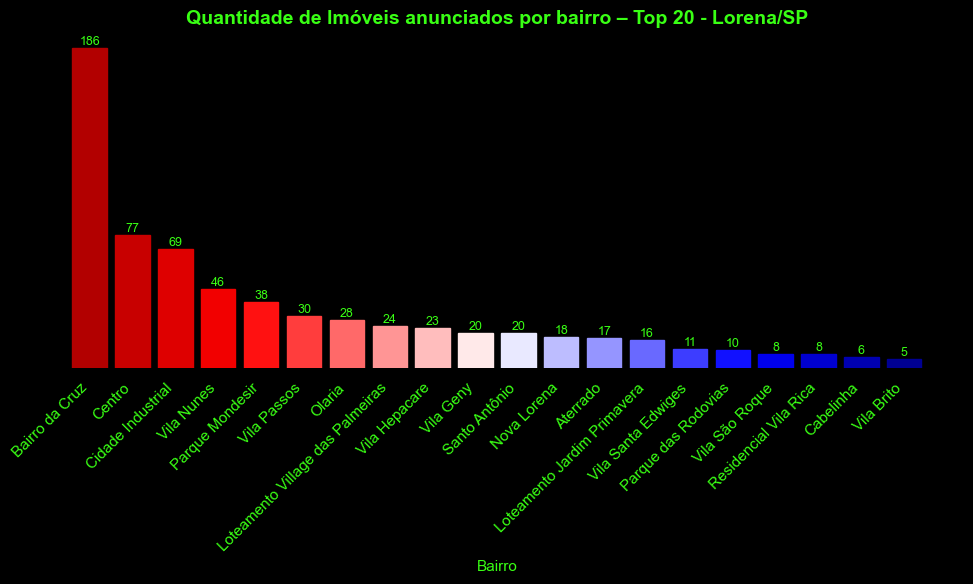

In [318]:
gerar_barras(
    contagem_bairros['bairro'],
    contagem_bairros['quantidade_imoveis'],
    titulo = 'Quantidade de Imóveis anunciados por bairro – Top 20 - Lorena/SP',
    colormap = 'seismic',
    tema = "darkgreen",
    tipo_valor = '',
    salvar_como = 'quantidade_de_imoveis_por_bairro.png',
    format_axis = {'seletor': True,
                    'eixos':['x','y'], 
                    'x_label':'Bairro', 
                    'y_label':'',
                    'rotation':{'x':45,'y':0}
                  },
    smart_bar_label=True,
    tamanho_fig=(10,6),
    grid=False,
    bordas=False,
    tamanho_fonte = {
    'titulo': 14,
    'eixos': 11,
    'rotulos': 9,
    }
)

### **Filtro para Imóveis residenciais - Lorena/SP**

In [319]:
# Filtro para pegar os bairros da área residencial da cidade de Lorena/SP
df_residencial = df_sem_outliers[
    (df_sem_outliers['quartos'] >= 1) &
    (df_sem_outliers['banheiros'] >= 1) & 
    (df_sem_outliers['vagas'] >= 1) & 
    (df_sem_outliers['bairro'] != "Área Rural de Lorena") &
    (df_sem_outliers['bairro'] != "Vila Portugal") &
    (df_sem_outliers['bairro'] != "Ponte Nova")
].copy()

### **Preço Médio de Imóveis Residenciais – Top 20 Bairros de Lorena/SP**

In [320]:
# cálculo do valor médio dos imóveis nos bairros residenciais de Lorena/SP, por bairro, top 10
preco_medio_por_bairro = (
    df_residencial
    .groupby('bairro', as_index=False)['preco']
    .mean()
    .astype({'preco': int})  # Converte a média para inteiro
    .sort_values(by='preco', ascending=False)
    .head(20)
)

print(preco_medio_por_bairro)

                              bairro    preco
6                   Jardim Margarida  1100000
1                     Bairro da Cruz   887289
4                             Centro   821102
8   Loteamento Village das Palmeiras   807457
11                   Parque Mondesir   669823
2                          Cabelinha   533800
17                         Vila Geny   531000
9                        Nova Lorena   500357
19                        Vila Nunes   482281
10                            Olaria   476000
18                     Vila Hepacare   446588
3                              Cecap   440000
5                  Cidade Industrial   438811
22                    Vila São Roque   409142
21                Vila Santa Edwiges   392375
16                        Vila Brito   389500
20                       Vila Passos   359826
15                     Santo Antônio   355999
14             Residencial Vila Rica   331800
23           Vila dos Comerciários I   316000


### **Preço Médio de Imóveis Residenciais – Top 20 Bairros de Lorena/SP**

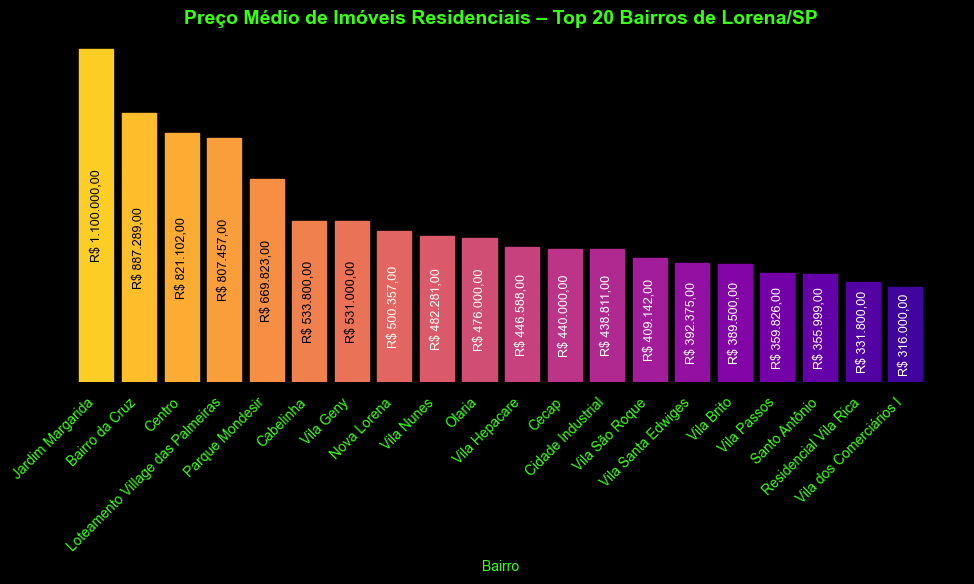

In [321]:
gerar_barras(
    categorias=preco_medio_por_bairro['bairro'],
    valores=preco_medio_por_bairro['preco'],
    titulo = 'Preço Médio de Imóveis Residenciais – Top 20 Bairros de Lorena/SP',
    colormap = 'plasma',
    tema = 'darkgreen',
    tipo_valor = 'moeda_br', 
    salvar_como = 'quantidade_de_imoveis_por_bairro.png',
    format_axis = {'seletor': True,
                    'eixos':['x','y'], 
                    'x_label':'Bairro', 
                    'y_label':'',
                    'rotation':{'x':45,'y':0}
                  },
    smart_bar_label=True,
    tamanho_fig=(10,6),
    grid=False,
    bordas=False,
    tamanho_fonte = {
    'titulo': 14,
    'eixos': 10,
    'rotulos': 9,
    }
)

### **Área média de imóveis residenciais - Top 20 bairros, Lorena/SP**

In [322]:
# cálculo do valor médio dos imóveis nos bairros residenciais de Lorena/SP, por bairro, top 10
media_area_por_bairro = (
    df_residencial
    .groupby('bairro', as_index=False)['area']
    .mean()
    .astype({'area': int})  # Converte a média para inteiro
    .sort_values(by='area', ascending=False)
    .head(20)
)

print(media_area_por_bairro)

                              bairro  area
6                   Jardim Margarida   465
16                        Vila Brito   330
4                             Centro   301
1                     Bairro da Cruz   296
11                   Parque Mondesir   259
19                        Vila Nunes   171
0                           Aterrado   171
2                          Cabelinha   163
10                            Olaria   159
22                    Vila São Roque   159
8   Loteamento Village das Palmeiras   159
23           Vila dos Comerciários I   158
9                        Nova Lorena   153
17                         Vila Geny   144
5                  Cidade Industrial   140
18                     Vila Hepacare   130
20                       Vila Passos   130
15                     Santo Antônio   120
21                Vila Santa Edwiges   115
14             Residencial Vila Rica   102


### **Gráfico - Área Média de Imóveis Residenciais – Top 20 Bairros de Lorena/SP**

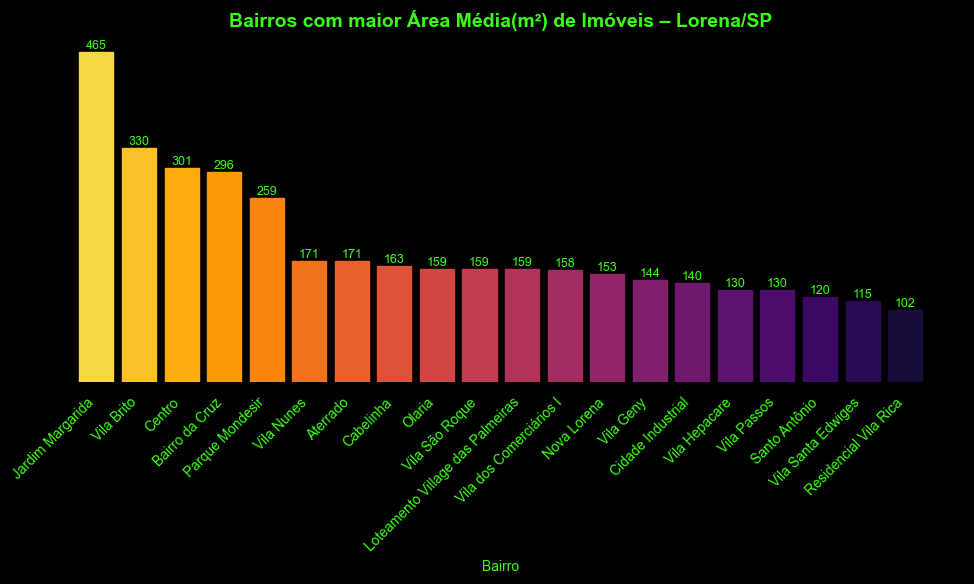

In [323]:
gerar_barras(
    categorias=media_area_por_bairro['bairro'],
    valores=media_area_por_bairro['area'],
    titulo = 'Bairros com maior Área Média(m²) de Imóveis – Lorena/SP',
    colormap = 'inferno',
    tema = 'darkgreen',
    tipo_valor = '', 
    salvar_como = 'area_media_por_bairro.png',
    format_axis = {'seletor': True,
                    'eixos':['x','y'], 
                    'x_label':'Bairro', 
                    'y_label':'',
                    'rotation':{'x':45,'y':0}
                  },
    smart_bar_label=True,
    tamanho_fig=(10,6),
    grid=False,
    bordas=False,
    tamanho_fonte = {
    'titulo': 14,
    'eixos': 10,
    'rotulos': 9,
    }
)

### **Valor médio do m² residencial por bairro, Lorena/SP (TOP 20)**

In [324]:
df_residencial['preco_m2'] = (df_residencial['preco'] / df_residencial['area']).round(2)
# Média do preço por m²
media_m2_bairro = (
    df_residencial
    .groupby('bairro', as_index=False)['preco_m2']
    .mean().round(2)
    .sort_values(by='preco_m2', ascending=False)
    .head(10)
)
print(media_m2_bairro)

                              bairro  preco_m2
5                  Cidade Industrial  36417.59
22                    Vila São Roque   7565.05
7        Loteamento Jardim Primavera   6361.25
8   Loteamento Village das Palmeiras   5229.74
3                              Cecap   4717.50
19                        Vila Nunes   4702.37
12               Parque das Rodovias   4304.45
17                         Vila Geny   4264.46
1                     Bairro da Cruz   4008.41
0                           Aterrado   3921.13


### **Gráfico - Valor médio do m² residencial por bairro, Lorena/SP (TOP 20)**

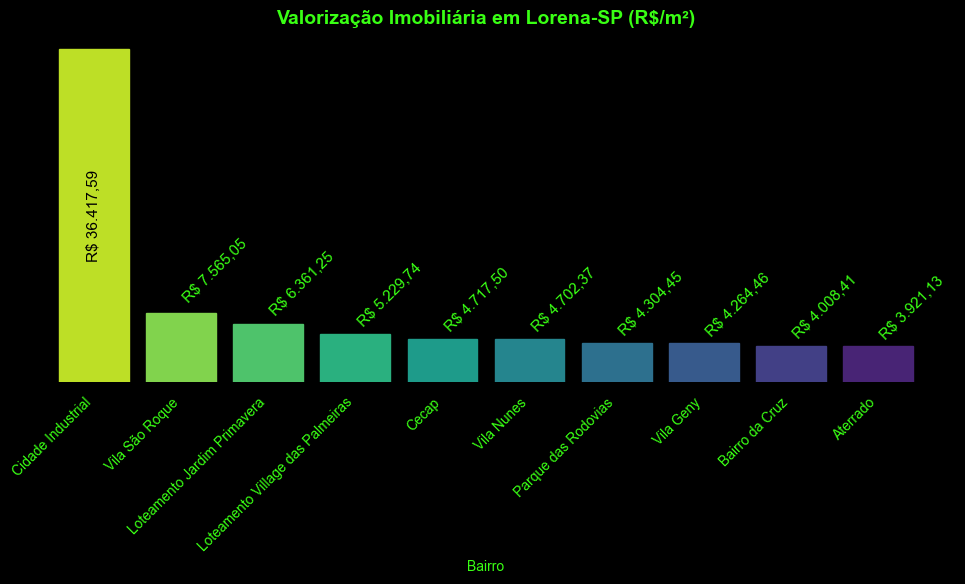

In [325]:
gerar_barras(
    categorias=media_m2_bairro['bairro'],
    valores=media_m2_bairro['preco_m2'],
    titulo = 'Valorização Imobiliária em Lorena-SP (R$/m²)',
    colormap = 'viridis',
    tema = 'darkgreen',
    tipo_valor = 'moeda_br', 
    salvar_como = 'valorizacao_imobiliaria_lorena.png',
    format_axis = {'seletor': True,
                    'eixos':['x','y'], 
                    'x_label':'Bairro', 
                    'y_label':'',
                    'rotation':{'x':45,'y':0}
                  },
    smart_bar_label=True,
    tamanho_fig=(10,6),
    grid=False,
    bordas=False,
    tamanho_fonte = {
    'titulo': 14,
    'eixos': 10,
    'rotulos': 11,
    }
)